In [ ]:
from ezfit import FitPDF, Contribution, Ezrestraint

from rsc import MPDF_Wrapper, AttrDict, r_gr_mgr, get_Tb1
import numpy as np
import matplotlib.pyplot as plt 

k13, a1, a2, a3, a4 = get_Tb1() # kvec and basis vectors for Tb1 which are the same for Tb2 and Tb3

Tb3Ni = Contribution(cif_name="Tb3Ni", cf_name="sphericalCF", formula="Tb3Ni")
fit = FitPDF(f"./data/Tb3Ni@58K.gr", [Tb3Ni])


mfit = MPDF_Wrapper(fit.cif_files["Tb3Ni"], AttrDict(fit.config))


mfit.add_magnetic_species(
    name=f"aTb3_1",
    ffparamkey="Tb3",
    strucIdxs=[0, 4, 8],
    basisvecs=a1,
    kvecs=[[k13]*12],
)

mfit.add_magnetic_species(
    name=f"aTb3_2",
    ffparamkey="Tb3",
    strucIdxs=[1, 5, 9],
    basisvecs=a2,
    kvecs=[[k13]*12],
)

mfit.add_magnetic_species(
    name=f"aTb3_3",
    ffparamkey="Tb3",
    strucIdxs=[2, 6, 10],
    basisvecs=a3,
    kvecs=[[k13]*12],
)

mfit.add_magnetic_species(
    name=f"aTb3_4",
    ffparamkey="Tb3",
    strucIdxs=[3, 7, 11],
    basisvecs=a4,
    kvecs=[[k13]*12],
)


mfit.set_up_MagStruc()


mfit.set_up_MagCalc()
fit.update_recipe()
mfit.register_mPDF_in_Structure(fit)
fit.LoadResFromFile("structural.res")


fit.run_fit()

In [ ]:
def gradient_f(x, f, args):
    # assert (x.shape[0] >= x.shape[1]), "the vector should be a column vector"
    # x = x.astype(float)
    # N = x.shape[0]
    gradient = []
    for param_key in x:
        if x[param_key].vary == False:
            continue
        if x[param_key] is None or x[param_key] == 0.0:
            x[param_key].set(1e-18)
        eps = abs(x[param_key].value) * np.finfo(np.float32).eps
        xx0 = 1. * x[param_key].value
        f0 = f(x, *args)
        x[param_key].set(x[param_key] + eps)
        f1 = f(x, *args)
        gradient.append(np.ndarray.item(np.array([f1 - f0])) / eps)
        x[param_key].set(xx0)
    return np.array(gradient)


# Hessian Matrix
def hessian(x, the_func, args):
    length = 0
    params_order = []
    for param_key in x:
        if x[param_key].vary == False:
            continue
        else:
            length += 1
    N = length
    hessian = np.zeros((N, N))
    gd_0 = gradient_f(x, the_func, args)
    # eps = np.linalg.norm(gd_0) * np.finfo(np.float32).eps
    i = 0
    for param_key in x:
        if x[param_key].vary == False:
            continue
        if x[param_key] is None or x[param_key] == 0.0:
            x[param_key].set(1e-18)
        eps = np.abs(x[param_key]) * np.finfo(np.float32).eps
        xx0 = 1. * x[param_key]
        x[param_key].set(xx0 + eps)
        gd_1 = gradient_f(x, the_func, args)
        hessian[:, i] = ((gd_1 - gd_0) / eps)
        x[param_key].set(xx0)
        i += 1
        params_order.append(param_key)
    return hessian, params_order


def calc_covar(x, the_func, args):
    hess, param_list = hessian(x, the_func, args)

    det_hess = np.linalg.slogdet(hess)

    _, det_neg_hess = np.linalg.slogdet(hess)
    try:
        cov = np.linalg.inv(hess)
        return cov, param_list
    except:
        return None

In [ ]:
params = {k: v for k, v in zip(fit.recipe.getNames(), fit.recipe.getValues())}
params

In [ ]:
hessian(params, fit.recipe.residual)

In [ ]:
%matplotlib tk
visMask = np.apply_along_axis(np.linalg.norm, 1, mfit.mstruc.atoms - mfit.mstruc.atoms[0]) < 6
visAtoms = mfit.mstruc.atoms[visMask]
visSpins = mfit.mstruc.spins[visMask]
mfit.mstruc.visualize(visAtoms, visSpins)

In [ ]:
fit.res.printResults()

In [ ]:
r, gobs, gcalc, magcalc, baseline, gdiff = r_gr_mgr(fit, mfit)

plt.plot(r, gobs, label="obs")
plt.plot(r, gcalc, label="calc", color="red")
plt.plot(r, magcalc - 10, label="mag")

plt.legend()

plt.savefig("mPDF_v1.pdf")

/Users/benjaminfahl/miniconda3/envs/py37/lib/python3.7/site-packages/diffpy.srfit-3.0.0-py3.7.egg/diffpy/srfit/fitbase/fitresults.py:174: RuntimeWarning: divide by zero encountered in true_divide
  self.cov = numpy.dot(vh.T.conj()/s**2,vh)
/Users/benjaminfahl/miniconda3/envs/py37/lib/python3.7/site-packages/diffpy.srfit-3.0.0-py3.7.egg/diffpy/srfit/fitbase/fitresults.py:174: RuntimeWarning: invalid value encountered in true_divide
  self.cov = numpy.dot(vh.T.conj()/s**2,vh)


Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       9570.26927222
Contributions  9570.26907115
Restraints     0.00020107
Chi2           9570.26907115
Reduced Chi2   3.29441276
Rw             0.39871795

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
Tb3Ni_Ni1_Biso  3.22929394e-01 +/- nan
Tb3Ni_Tb1_Biso  6.69895550e-01 +/- nan
Tb3Ni_Tb2_Biso  1.53914771e-01 +/- nan
Tb3Ni_a         6.52392798e+00 +/- nan
Tb3Ni_b         9.29962108e+00 +/- nan
Tb3Ni_c         6.35004956e+00 +/- nan
Tb3Ni_delta2    1.00000000e+00 +/- inf
ordscale        9.02394897e-02 +/- nan
parascale       6.14308959e-01 +/- nan
xi              8.85590048e+00 +/- nan

Fixed Variables
------------------------------------------------------------------------------
Tb3Ni_Ni1_occ  1.00001418e+00
Tb3Ni_Ni1_x    1.13310781e-

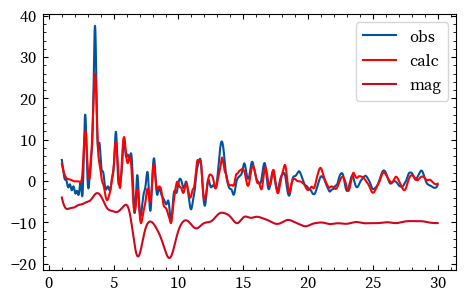

In [3]:
from ezfit import FitPDF, Contribution, Ezrestraint
from ezplot import plot_defaults
from rsc import MPDF_Wrapper, AttrDict, r_gr_mgr, get_Tb1
from diffpy.mpdf.mciftools import create_from_mcif
import numpy as np
import matplotlib.pyplot as plt 





for T in [10, 30, 50, 58, 65, 70, 85, 110, 150, 300][:1]:
    Tb3Ni = Contribution(cif_name="Tb3Ni", cf_name="bulkCF", formula="Tb3Ni")

    fit = FitPDF(f"./data/Tb3Ni@{T}K.gr", [Tb3Ni])


    mfit = MPDF_Wrapper(fit.cif_files["Tb3Ni"], AttrDict(fit.config))


    mfit.mstruc = create_from_mcif("cifs/Tb3Ni@58K.mcif", ffparamkey="Tb3")

    mfit.set_up_MagCalc()
    fit.update_recipe()
    mfit.register_mPDF_in_Structure(fit)
    fit.LoadResFromFile("structural.res")
    
    fit.run_fit()

    r, gobs, gcalc, magcalc, baseline, gdiff = r_gr_mgr(fit, mfit)

    fig, gs = plot_defaults(1, 1)
    ax = fig.add_subplot(gs[0, 0])
    ax.plot(r, gobs, label="obs")
    ax.plot(r, gcalc, label="calc", color="red")
    ax.plot(r, magcalc - 10, label="mag")

    ax.legend()
    fit.res.saveResults(f"res/mPDF_T{T}K_mcif.res")
    plt.savefig(f"res/mPDF_T{T}K_mcif.pdf")

    

In [ ]:
fit.recipe.equation

In [ ]:
%matplotlib tk
visMask = np.apply_along_axis(np.linalg.norm, 1, mfit.mstruc.atoms - mfit.mstruc.atoms[0]) < 6
visAtoms = mfit.mstruc.atoms[visMask]
visSpins = mfit.mstruc.spins[visMask]
mfit.mstruc.visualize(visAtoms, visSpins)

In [ ]:
fit.res.printResults()